In [1]:
import pandas as pd
import numpy as np
from numpy import quantile, where, random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [2]:
df_tr_1 = pd.read_csv("C:/Users/User/github/data/TFTLCD/ph1_bytime.csv", encoding='cp949')
df_ts_1 = pd.read_csv("C:/Users/User/github/data/TFTLCD/ph2_in.csv", encoding='cp949')
df_ts_2 = pd.read_csv("C:/Users/User/github/data/TFTLCD/ph2_out.csv", encoding='cp949')

In [3]:
df_tr = df_tr_1.iloc[:, 7:50] # train
df_ts = pd.concat([df_ts_1.iloc[:,7:50], df_ts_2.iloc[:,7:50]])

In [4]:
df_tr = df_tr.replace('Normal', 0)
df_ts = df_ts.replace('정상', 0)
df_ts = df_ts.replace('이상', 1)

In [5]:
df_ts = df_ts.rename(columns={'추가정보_정상.이상여부':'Normal/Abnormal'})

In [6]:
df_tr_x = df_tr.iloc[:,:-1]
df_tr_y = df_tr.iloc[:,-1]
df_ts_x = df_ts.iloc[:,:-1]
df_ts_y = df_ts.iloc[:,-1]

In [7]:
scaler = StandardScaler()
scaler.fit(df_tr_x)
#df_tr_x = scaler.transform(df_tr_x)
scaler.fit(df_ts_x)
#df_ts_x = scaler.transform(df_ts_x)

StandardScaler()

In [8]:
model = OneClassSVM(gamma='auto')

In [9]:
param_grid = {
    'kernel': ['rbf','poly','linear'],
    'nu': [0.001, 0.01, 0.5, 0.1, 0.2, 0.3]
}

In [10]:
grid_search = GridSearchCV(model, param_grid, scoring='f1_weighted', cv=5, verbose=1)

In [11]:
grid_search.fit(df_tr_x)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=OneClassSVM(gamma='auto'),
             param_grid={'kernel': ['rbf', 'poly', 'linear'],
                         'nu': [0.001, 0.01, 0.5, 0.1, 0.2, 0.3]},
             scoring='f1_weighted', verbose=1)

In [12]:
best_params = grid_search.best_params_
print(f'Best Parmas:{best_params}')

Best Parmas:{'kernel': 'rbf', 'nu': 0.001}


In [13]:
svm_fit = OneClassSVM(**best_params, gamma='auto')
svm_fit.fit(df_tr_x)

OneClassSVM(gamma='auto', nu=0.001)

In [14]:
df_ts_y.iloc[:,]

0      0
1      0
2      0
3      0
4      0
      ..
995    1
996    1
997    1
998    1
999    1
Name: Normal/Abnormal, Length: 2000, dtype: int64

In [15]:
# Predict the anomalies
prediction = svm_fit.predict(df_ts_x)
# Change the anomalies' values to make it consistent with the true values
prediction = [1 if i==-1 else 0 for i in prediction]
# Check the model performance
print(classification_report(df_ts_y.iloc[:,], prediction))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01      1000
           1       0.50      1.00      0.67      1000

    accuracy                           0.50      2000
   macro avg       0.75      0.50      0.34      2000
weighted avg       0.75      0.50      0.34      2000



In [16]:
df_tr_1 = pd.read_csv("C:/Users/User/github/data/TFTLCD/ph1_bytime.csv", encoding='cp949')
df_ts_1 = pd.read_csv("C:/Users/User/github/data/TFTLCD/ph2_in.csv", encoding='cp949')
df_ts_2 = pd.read_csv("C:/Users/User/github/data/TFTLCD/ph2_out.csv", encoding='cp949')

df_tr = df_tr_1.iloc[:, 7:50] # train
df_ts = pd.concat([df_ts_1.iloc[:,7:50], df_ts_2.iloc[:,7:50]], ignore_index=True)

df_tr = df_tr.replace('Normal', 0)
df_ts = df_ts.replace('정상', 0)
df_ts = df_ts.replace('이상', 1)

df_ts = df_ts.rename(columns={'추가정보_정상.이상여부':'Normal/Abnormal'})

df_tr_x = df_tr.iloc[:,:-1]
df_tr_y = df_tr.iloc[:,-1]
df_ts_x = df_ts.iloc[:,:-1]
df_ts_y = df_ts.iloc[:,-1]

In [17]:
df_tr_x.drop(index=1417, inplace=True)
df_tr_y.drop(index=1417, inplace= True)
df_ts_x.drop(index=1417, inplace=True)
df_ts_y.drop(index=1417, inplace= True)

In [18]:
class convers_pca():
    def __init__(self, no_of_components):
        self.no_of_components = no_of_components
        self.eigen_values = None
        self.eigen_vectors = None
        
    def transform(self, x):
        return np.dot(x - self.mean, self.projection_matrix.T)
    
    def inverse_transform(self, x):
        return np.dot(x, self.projection_matrix) + self.mean
    
    def fit(self, x):
        self.no_of_components = x.shape[1] if self.no_of_components is None else self.no_of_components
        self.mean = np.mean(x, axis=0)
        
        cov_matrix = np.cov(x - self.mean, rowvar=False)
        
        self.eigen_values, self.eigen_vectors = np.linalg.eig(cov_matrix)
        self.eigen_vectors = self.eigen_vectors.T
        
        self.sorted_components = np.argsort(self.eigen_values)[::-1]
        
        self.projection_matrix = self.eigen_vectors[self.sorted_components[:self.no_of_components]]

        self.explained_variance = self.eigen_values[self.sorted_components]
        self.explained_variance_ratio = self.explained_variance / self.eigen_values.sum()

In [19]:
std = StandardScaler()
transformed = StandardScaler().fit_transform(df_tr_x)

In [20]:
pca = convers_pca(no_of_components=2)
pca.fit(transformed)

In [21]:
x_std = pca.transform(transformed)

In [23]:
std = StandardScaler()
transformed_2 = StandardScaler().fit_transform(x_std)

pca_2 = convers_pca(no_of_components=3)
pca_2.fit(transformed_2)

x_std_2 = pca_2.transform(transformed_2)

In [24]:
len(df_ts_y)

1999

In [25]:
best_params = grid_search.best_params_
print(f'Best Parmas:{best_params}')
svm_fit = OneClassSVM(**best_params, gamma='auto')
svm_fit.fit(x_std)

# Predict the anomalies
prediction = svm_fit.predict(x_std)
# Change the anomalies' values to make it consistent with the true values
prediction = [1 if i==-1 else 0 for i in prediction]
# Check the model performance
print(classification_report(df_ts_y.iloc[:,], prediction))

# Get the scores for the testing dataset
score = svm_fit.score_samples(x_std)
# Check the score for 2% of outliers
score_threshold = np.percentile(score, 2)
print(f'The customized score threshold for 2% of outliers is {score_threshold:.2f}')
# Check the model performance at 2% threshold
customized_prediction = [1 if i < score_threshold else 0 for i in score]
# # Check the prediction performance
print(classification_report(df_ts_y.iloc[:,], customized_prediction))

Best Parmas:{'kernel': 'rbf', 'nu': 0.001}
              precision    recall  f1-score   support

           0       0.50      0.97      0.66      1000
           1       0.47      0.02      0.04       999

    accuracy                           0.50      1999
   macro avg       0.48      0.50      0.35      1999
weighted avg       0.48      0.50      0.35      1999

The customized score threshold for 2% of outliers is 0.15
              precision    recall  f1-score   support

           0       0.50      0.98      0.66      1000
           1       0.45      0.02      0.03       999

    accuracy                           0.50      1999
   macro avg       0.47      0.50      0.35      1999
weighted avg       0.47      0.50      0.35      1999



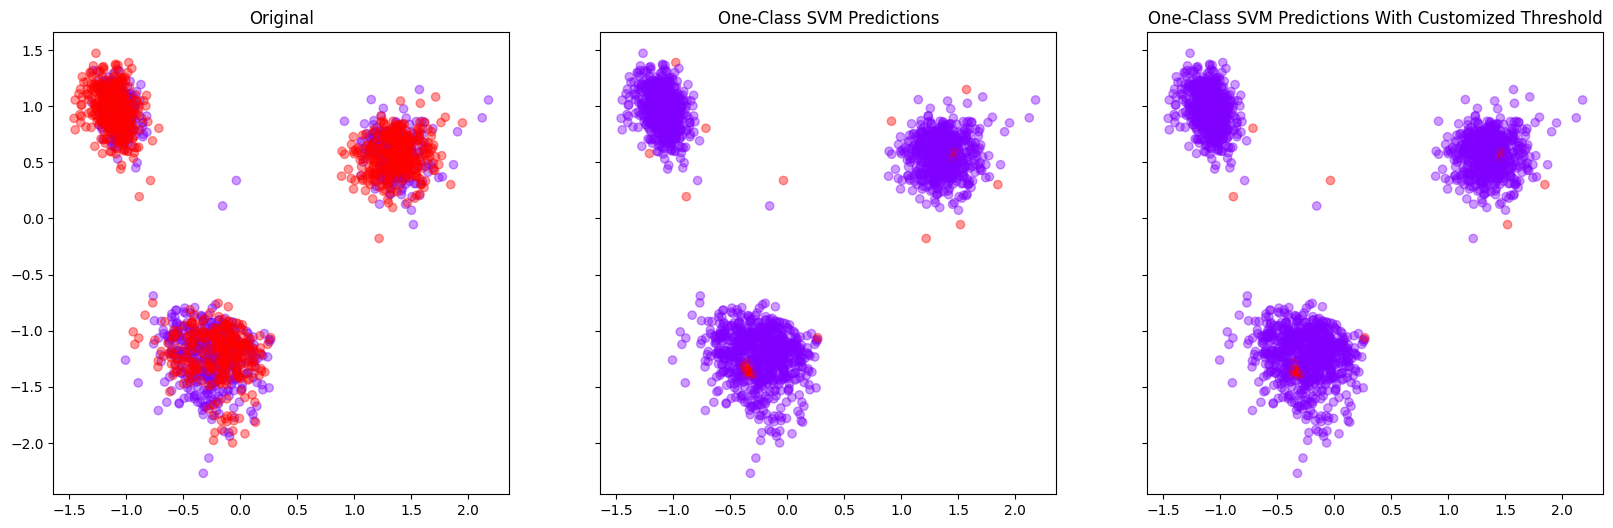

In [26]:
# Put the testing dataset and predictions in the same dataframe
df_test = pd.DataFrame(x_std_2, columns=['feature1', 'feature2'])
df_test['y_test'] = df_ts_y.iloc[:,]
df_test['one_class_svm_prediction'] = prediction
df_test['one_class_svm_prediction_cutomized'] = customized_prediction
# Visualize the actual and predicted anomalies
fig, (ax0, ax1, ax2)=plt.subplots(1,3, sharey=True, figsize=(20,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow', alpha = 0.4)
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction'], cmap='rainbow', alpha = 0.4)
# One-Class SVM Predictions With Customized Threshold
ax2.set_title('One-Class SVM Predictions With Customized Threshold')
ax2.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction_cutomized'], cmap='rainbow',  alpha = 0.4)